## Explore the Zillow Data

* Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

* Answer those questions through a mix of statistical tests and visualizations.

__Acquire the data__

In [1]:
import numpy as np
import pandas as pd
import env
import wrangle_excs
import wrangle_zillow
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
zillow = wrangle_excs.wrangle_zillow()

In [3]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69523 entries, 0 to 77380
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   69523 non-null  float64
 1   bedroomcnt                    69523 non-null  float64
 2   buildingqualitytypeid         69523 non-null  float64
 3   calculatedfinishedsquarefeet  69523 non-null  float64
 4   fips                          69523 non-null  float64
 5   latitude                      69523 non-null  float64
 6   longitude                     69523 non-null  float64
 7   lotsizesquarefeet             69523 non-null  float64
 8   rawcensustractandblock        69523 non-null  float64
 9   regionidcity                  69523 non-null  float64
 10  regionidcounty                69523 non-null  float64
 11  regionidzip                   69523 non-null  float64
 12  roomcnt                       69523 non-null  float64
 13  u

__Prepare Zillow Data__

In [4]:
#The data is mostly prepared, just need to remove some outliers
#Now remove things that don't make sense and/or are impossible/illegal.
#If something doesn't sound like the average 'single unit' property, drop it.
zillow = zillow[(zillow.bedroomcnt > 0) & (zillow.bathroomcnt> 0)]
zillow = zillow[zillow.bedroomcnt <= 5]
zillow = zillow[zillow.bathroomcnt <= 3]
zillow = zillow[zillow['calculatedfinishedsquarefeet'] <= 5000]
zillow = zillow[zillow['calculatedfinishedsquarefeet'] >= (120 * zillow.bedroomcnt)]
zillow = zillow[zillow.taxamount <= 20_000]

In [5]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63358 entries, 1 to 77380
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   63358 non-null  float64
 1   bedroomcnt                    63358 non-null  float64
 2   buildingqualitytypeid         63358 non-null  float64
 3   calculatedfinishedsquarefeet  63358 non-null  float64
 4   fips                          63358 non-null  float64
 5   latitude                      63358 non-null  float64
 6   longitude                     63358 non-null  float64
 7   lotsizesquarefeet             63358 non-null  float64
 8   rawcensustractandblock        63358 non-null  float64
 9   regionidcity                  63358 non-null  float64
 10  regionidcounty                63358 non-null  float64
 11  regionidzip                   63358 non-null  float64
 12  roomcnt                       63358 non-null  float64
 13  u

__Check Variable Distributions__

In [6]:
#Plot the individual distributions
def get_dists(df):
    for col in df.columns:
        sns.histplot(x = col, data = df)
        plt.title(col)
        plt.show()

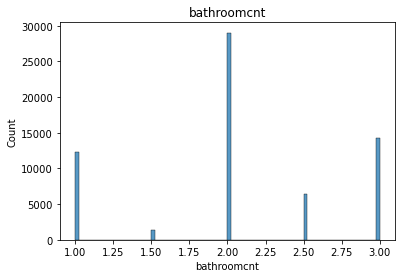

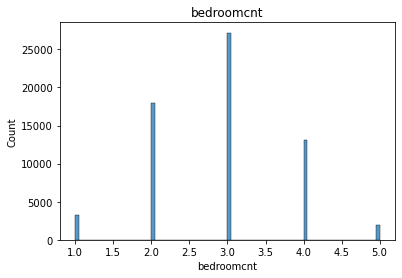

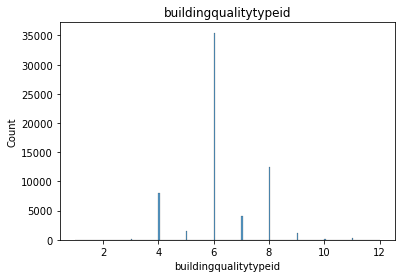

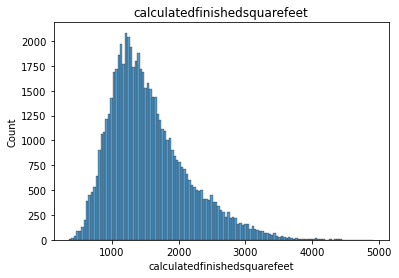

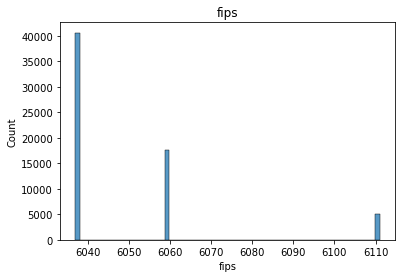

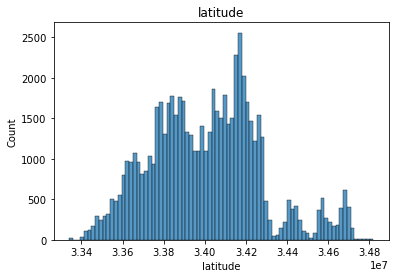

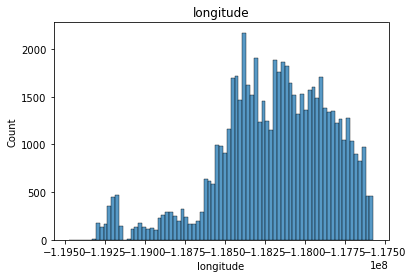

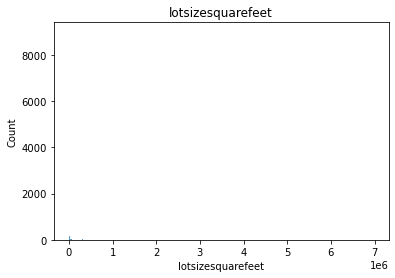

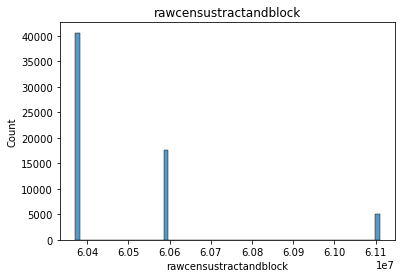

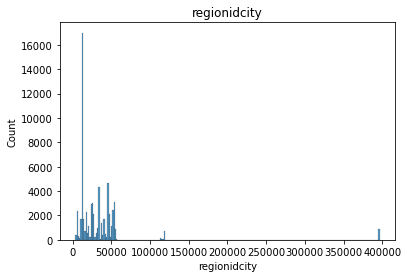

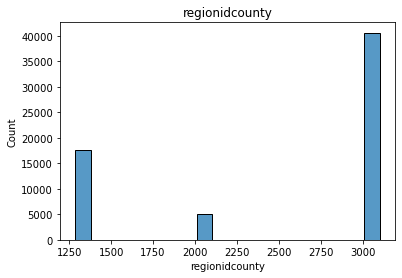

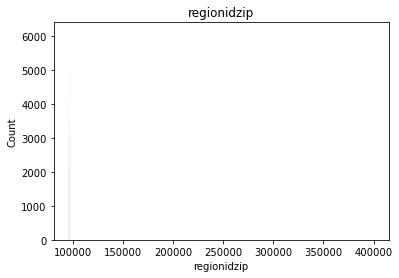

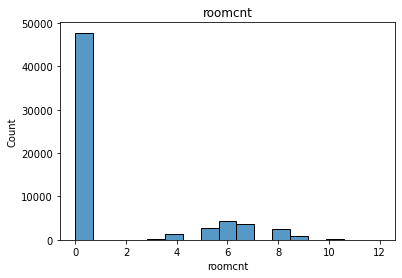

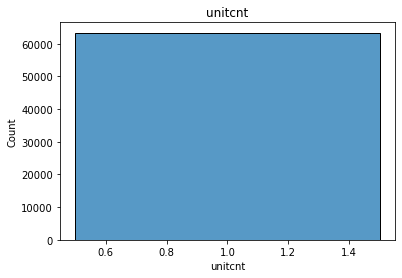

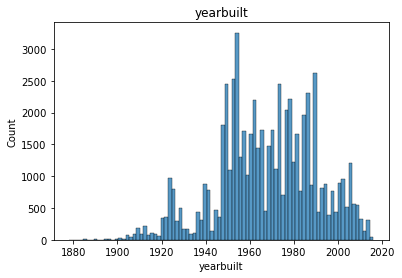

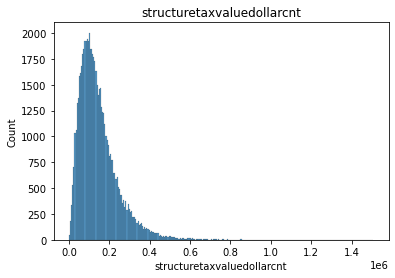

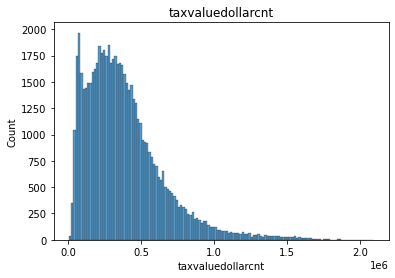

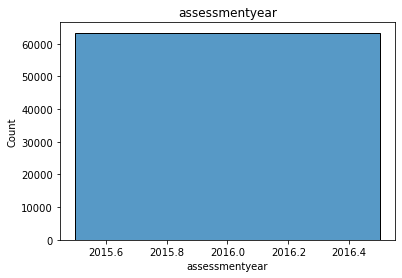

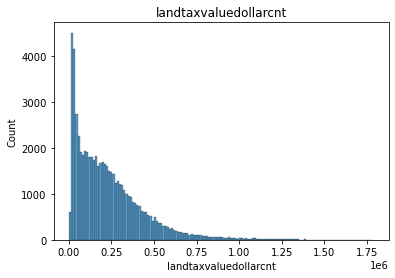

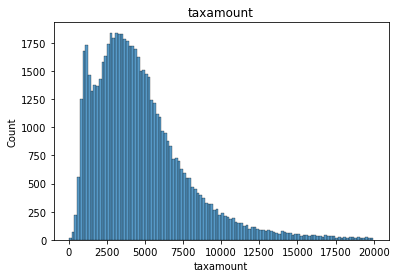

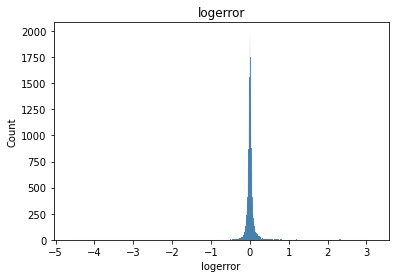

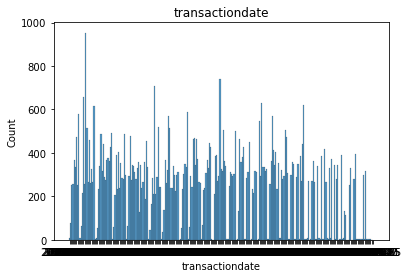

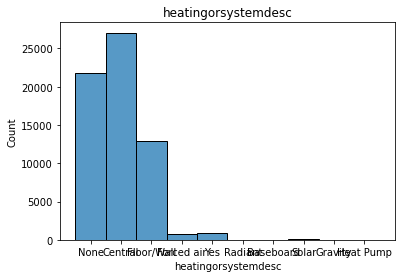

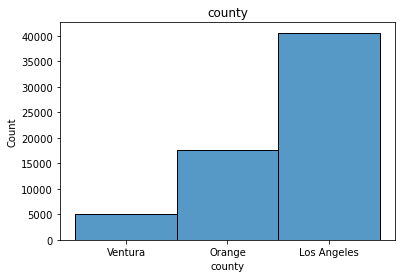

In [7]:
get_dists(zillow)

In [8]:
#Now split the data into train, validate, test
train, validate, test = wrangle_excs.train_validate_test_split(zillow)

__Explore the Data__

__Question 1: Is log error significantly different for properties from county to county?__

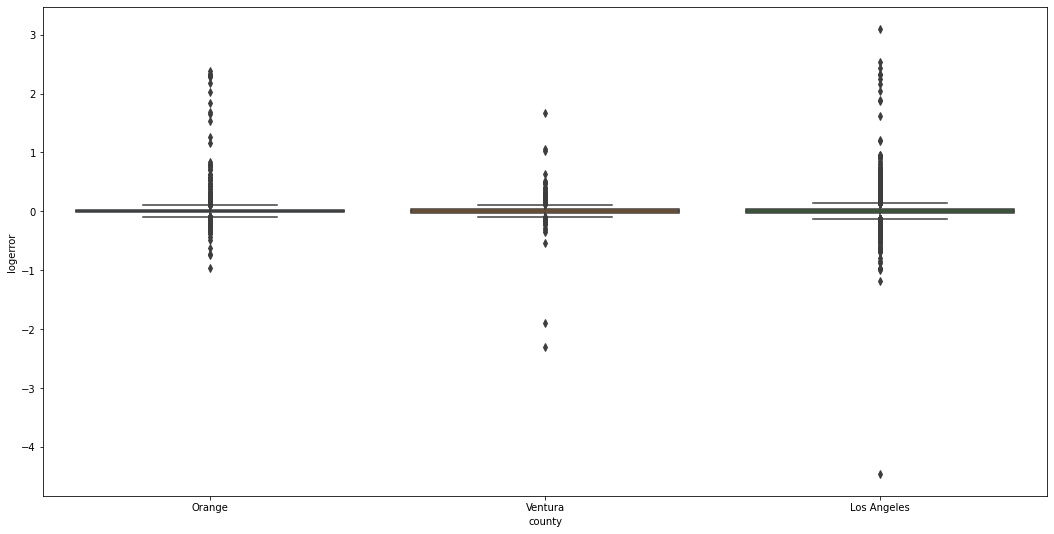

In [9]:
#Visualize
plt.figure(figsize=(18,9))
sns.boxplot(x = 'county', y = 'logerror', data = train.sample(9000))
plt.show()

Its hard to make any judgement calls on the figure alone, so I'll use statistical testing to verify.

__LA County Vs. Orange County__

$H_0$: Average logerror for properties in Los Angelas County == Average logerror for properties in Orange County.

$H_a$: Average logerror for properties in Los Angels County != Average logerror for properties in Orange County.

In [10]:
alpha = 0.05

In [11]:
#Create sets for each county
la_county = train[train.county == 'Los Angeles'].copy()
orange_county = train[train.county == 'Orange'].copy()
ventura_county = train[train.county == 'Ventura'].copy()

In [12]:
#Assume variances are not equal.
t, p = stats.ttest_ind(la_county.logerror, orange_county.logerror, equal_var = False)
t, p

(-2.1727232959066822, 0.029814276626947973)

__Result__

p-value is less than 0.05, so we reject the null hypothesis. Average logerror for properties in Los Angeles County is significantly different than average logerror for properties in Orange County.

__LA County Vs. Ventura County__

$H_0$: Average logerror for properties in Los Angelas County == Average logerror for properties in Ventura County.

$H_a$: Average logerror for properties in Los Angels County != Average logerror for properties in Ventura County.

In [13]:
alpha = 0.05

In [14]:
#Assume variances are not equal
t, p = stats.ttest_ind(la_county.logerror, ventura_county.logerror, equal_var = False)
t, p

(-0.29868364589589075, 0.765197980651783)

__Result__

p-value is greater than 0.05, so we fail to reject the null hypothesis. Average logerror for properties in Los Angeles County is not significantly different than the average logerror for properties in Ventura County.

__Orange County Vs. Ventura County__

$H_0$: Average logerror for properties in Orange County == Average logerror for properties in Ventura County.

$H_a$: Average logerror for properties in Orange County != Average logerror for properties in Ventura County.

In [15]:
alpha = 0.05

In [16]:
#Assume variances are not equal
t, p = stats.ttest_ind(orange_county.logerror, ventura_county.logerror, equal_var = False)
t, p

(1.0001750389987096, 0.3172715627522714)

__Result__

p-value is greater than 0.05, so we fail to reject the null hypothesis. Average logerror for properties in Orange County is not significantly different than the average logerror for properties in Ventura County.

__Key Takeaways:__
    
* Average logerror for properties in Los Angeles County is significantly different than the average logerror for properties in Orange County, but there is no significant difference between the others.
* For this reason, I'm not sure that county would be a good feature in and of itself, but maybe further exploration will be able to explain these findings.

__Question 2: Is there a relationship between the age of the property and the log error?__

In [17]:
#Create the age column
train['age'] = 2017 - train.yearbuilt

<Figure size 1296x648 with 0 Axes>

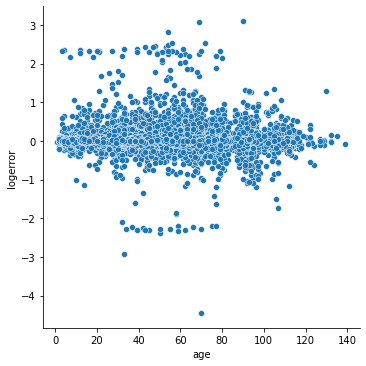

In [18]:
#Plot age and logerror
plt.figure(figsize=(18,9))
sns.relplot(x = 'age', y = 'logerror', data = train)
plt.show()

logerror seems fairly consistent with only two outlier groups. One above and one below the average. It also appears to have less error overall for properties about 90 years old or older.

In [24]:
#Try creating groups out of the age
train['age_bin'] = pd.cut(train.age, bins = [0, 30, 60, 90, 140])

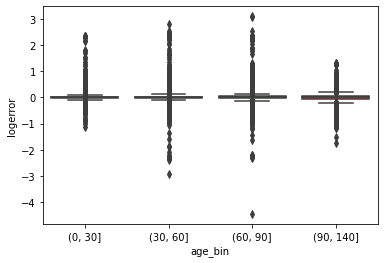

In [25]:
sns.boxplot(x = 'age_bin', y = 'logerror', data = train)
plt.show()

The age groups 0 to 30 and 90 to 140 both seem to have smaller logerrrors on average compared to the other two age groups.

$H_0$: The average logerror for properties greater than or equal to 90 years old == The average logerror for all other properties.
    
$H_a$: The average logerror for properties greater than or equal to 90 years old != The average logerror for all other properties.

In [26]:
alpha = 0.05

In [27]:
#Assume variances are not equal
t, p = stats.ttest_ind(train[train.age >= 90].logerror, train[train.age < 90].logerror, equal_var = False)
t, p

(-2.2353850380938005, 0.02547857995176925)

p-value is less than 0.05, so we reject the null hypothesis. The average logerror for homes greater than or equal to 90 years old is significantly different than the logerror for homes less than 90 years old.

__Homes that are >= 90 years old Vs. homes that are <= 30 years old.__

$H_0$: The average logerror for properties greater than or equal to 90 years old == The average logerror for properties less than or equal to 30 years old.
    
$H_a$: The average logerror for properties greater than or equal to 90 years old != The average logerror for properties less than or equal to 30 years old.

In [28]:
alpha = 0.05

In [29]:
t, p = stats.ttest_ind(train[train.age >= 90].logerror, train[train.age <= 30].logerror, equal_var = False)
t, p

(-1.9724935368512364, 0.04864839597008676)

Since p-value is less than 0.05, we reject the null hypothesis. The average logerror for properties greater than or equal to 90 years old is significantly different than the average logerror for properties less than or equal to 30 years old.

__Key Takeaways:__
    
* I think that age group as a categorical feature may be a good idea
* Log error is signficantly different for properties >= 90 years old when compared to all other properties.
* Log error is significantly different for properties >= 90 years old when compared to properties that are <= 30 years old.

__Question 3: Does logerror have a relationship with taxvaluedollarcnt?__

<Figure size 1296x648 with 0 Axes>

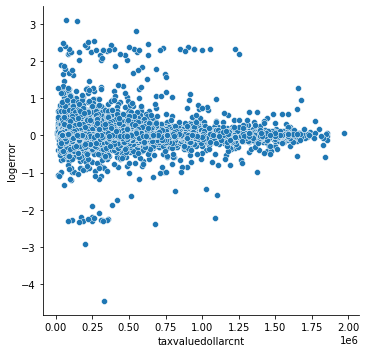

In [30]:
plt.figure(figsize=(18,9))
sns.relplot(x = 'taxvaluedollarcnt', y = 'logerror', data = train)
plt.show()

Logerror seems to decrease on average as home get more expensive. Is there a linear relationship?


$H_0$: logerror is not linearly correlated with taxvaluedollarcnt.

$H_a$: logerror is linearly correlated with taxvaluedollarcnt.

In [31]:
alpha = 0.05

In [32]:
corr, p = stats.pearsonr(train.logerror, train.taxvaluedollarcnt)
corr, p

(-0.017243593221268772, 0.0007733706867103638)

Since p-value is less than 0.05, we reject the null hypothesis. Logerror is linearly correlated with taxvaluedollarcnt, but only weakly so.

__Key Takeaways:__
    
* Logerror is negatively linearly correlated with taxvaluedollarcnt, but only weakly so.
* There must be a reason for the negative correlation.

__Question 4: Does logerror have a relationship with building quality type?__

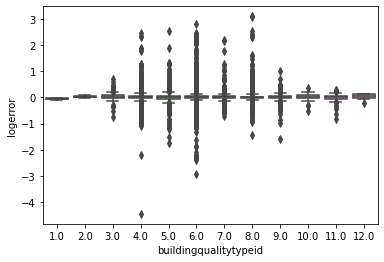

In [34]:
sns.boxplot(x = train.buildingqualitytypeid, y = train.logerror)
plt.show()

Log error seems to be the worst for the average quality homes ranging from a quality type of 4 to 8, but is much less for the extremes quality groups. Groups 1 to 3, the best qualities, seem to have about the same logerror as groups 9 to 12, the worst qualities.

$H_0$: The average logerror for buildingqualitytypeid 4 to 8 is == The average logerror for buildingqualitytypeid less than or equal to 3.
    
$H_a$: The average logerror for buildingqualitytypeid 4 to 8 is != The average logerror for buildingqualitytypeid less than or equal to 3.

In [35]:
alpha = 0.05

In [44]:
#Create groups for each range of buildingqualitytypeid
mid_quality = train[(train.buildingqualitytypeid >= 4.0) & (train.buildingqualitytypeid <= 8.0)]
high_quality = train[(train.buildingqualitytypeid <= 3.0)]
low_quality = train[(train.buildingqualitytypeid >= 9.0)]

In [45]:
t, p = stats.ttest_ind(mid_quality.logerror, high_quality.logerror, equal_var = False)
t, p

(-0.6169011232501359, 0.5387859600166472)

Since p-value is greater than 0.05, we fail to reject the null hypothesis. The average logerror for mid-quality homes is not significantly different than the average logerror for high-quality homes.

$H_0$: The average logerror for high-quality homes == the average logerror for low-quality homes.
    
$H_a$: The average logerror for high-quality homes != the average logerror for low-quality homes.

In [46]:
alpha = 0.05

In [48]:
t, p = stats.ttest_ind(high_quality.logerror, low_quality.logerror, equal_var = False)
t, p

(1.257403128781154, 0.21145766529905252)

Since p-value is greater than 0.05, we fail to reject the null hypothesis. The average log error for high quality homes is not significantly different than the average log error for low-quality homes.

__Key Takeaways__

* Despite my initial thoughts, there are no significant differences between the average log errors of each quality group.
* However, it does seem like something is causing greater logerror outliers in the mid-range quality homes.

__Question 5: Is there a relationship between latitude and logerror?__

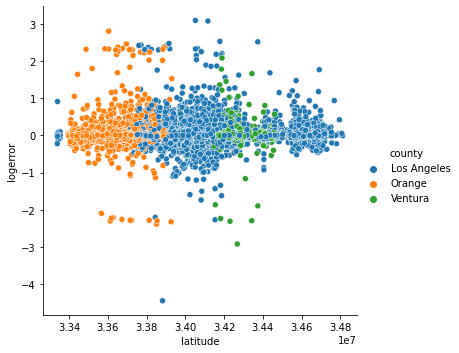

In [52]:
sns.relplot(x = 'latitude', y = 'logerror', hue = 'county', data = train)
plt.show()

At first glance there doesn't seem to be much going on here, but it does look like that as latitude increases, the range of logerror decreases.

__Question 6: Is there a relationship between longitude and logerror?__

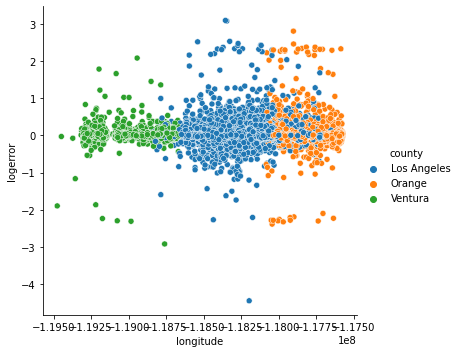

In [53]:
sns.relplot(x = 'longitude', y = 'logerror', hue = 'county', data = train)
plt.show()

In [81]:
#create bins for logerror and use that as a hue in a chart of longitude and latitude
train['error_bin'] = pd.cut(train.logerror, bins = [-5, -1, 0, .05, .1, .15, .2, 4])
train.error_bin.value_counts()

(-1.0, 0.0]     16904
(0.0, 0.05]     14053
(0.05, 0.1]      3641
(0.2, 4.0]       1509
(0.1, 0.15]      1235
(0.15, 0.2]       632
(-5.0, -1.0]       40
Name: error_bin, dtype: int64

<Figure size 1296x648 with 0 Axes>

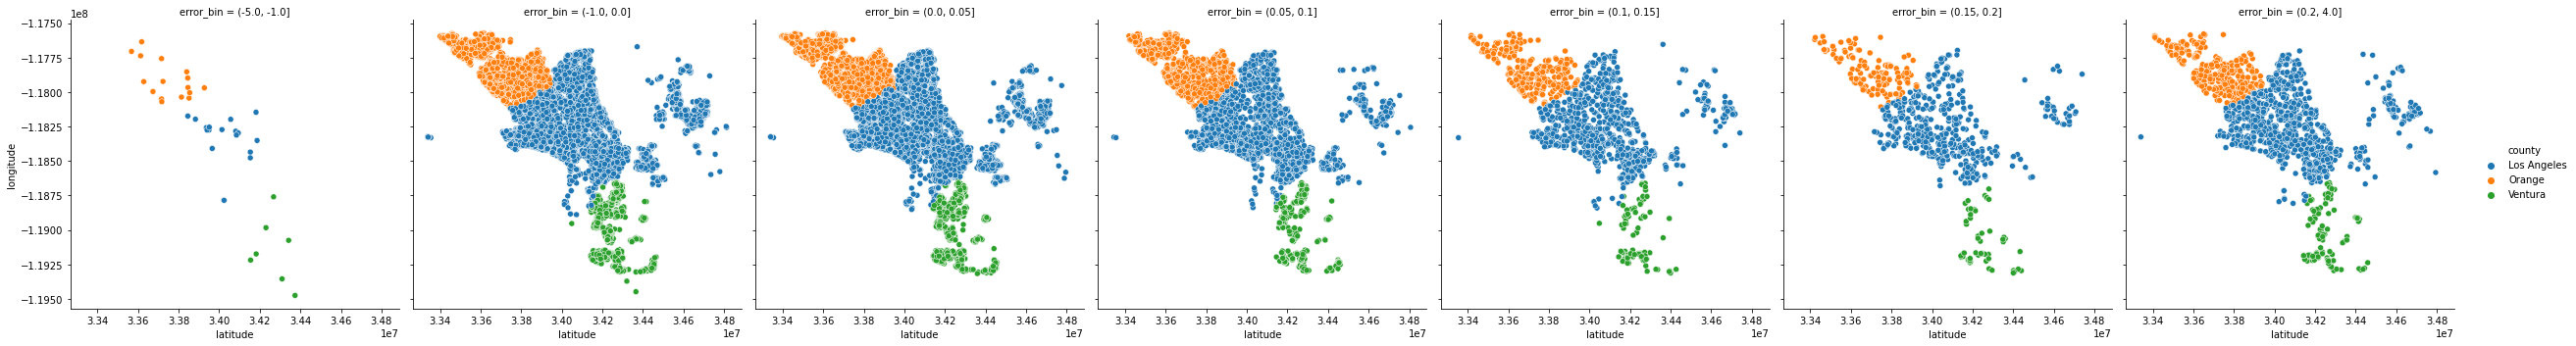

In [84]:
plt.figure(figsize=(18,9))
sns.relplot(x = 'latitude', y = 'longitude', hue = 'county', col = 'error_bin', data = train)
plt.show()

After some time playing with the graph above, I haven't really found anything worthwhile.

__Is there a relationship between home size and log error?__

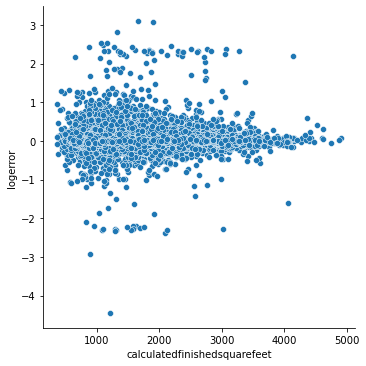

In [86]:
sns.relplot(x = 'calculatedfinishedsquarefeet', y = 'logerror', data = train)
plt.show()

This graph appears similar to the one comparing logerror and taxvaluedollarcnt, which isn't surprising since home size is a driving factor of tax value. Why does logerror have a greater spread for the cheaper, smaller homes? What separates them from the rest?

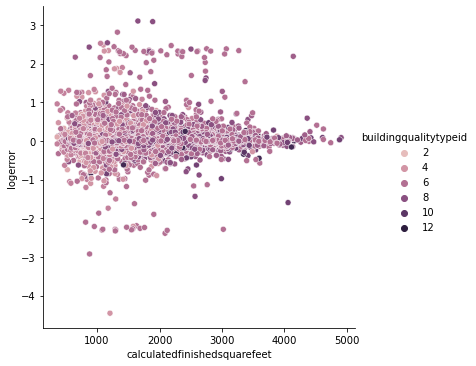

In [91]:
#Try using heatingsystem type as a hue
sns.relplot(x='calculatedfinishedsquarefeet', y = 'logerror', hue = 'buildingqualitytypeid', data = train)
plt.show()

It appears that homes with Floor/Wall systems have a greater logerror than the other types. It also appears that the smaller, cheaper homes have Floor/Wall heating systems. 

$H_0$: The average logerror of homes with Floor/Wall systems == The average logerror of homes without Floor/Wall systems.
    
$H_a$: The average logerror of homes with Floor/Wall systems != The average logerror of homes without Floor/Wall systems.
    
alpha = 0.05

In [90]:
t, p = stats.ttest_ind(train[train.heatingorsystemdesc == 'Floor/Wall'].logerror, train[train.heatingorsystemdesc != 'Floor/Wall'].logerror, equal_var = False)
t, p

(-0.8527560784891975, 0.3938127755980836)

Since p-value is greater than 0.05, we fail to reject the null hypothesis. The average logerror of homes with Floor/Wall systems is not significantly different than the average logerror of homes without Floor/Wall systems.